In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import xesmf as xe
import sys
sys.path.append('../glac1d_meltwater')
import glac1d_toolbox as tb
import routing as routing
import plotting as plotting

/home/olnavy/anaconda3/envs/Olnavy/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# Demonstration routing algorithm

**Objective** : Compute an algorithm that transform the GLAC1D trnsient reconstruction associated with a routing map to a transient meltwater mask given a land sea mask. It will execute the following operations : 
- Transform the ice thickness differences in volumetric fluxes (m -> m3/s, -26,0). Remove negative values.
- Smooth the results. Propose different modes (differential by default)
- Route the ice differences to the associated pointers (conservation of total flux)
- Regrid to HadCM3 grid
- Deal with points overlapping the land sea mask and send them to the closest sea point.

## Inputs

**Land Sea Mask** : experiment name <-> time table is available on GitHub.  

In [2]:
ds_lsm = xr.open_dataset('/Documents/Documents/Cours/PHD/data/Proj_GLAC1D/ocean_masks/teadv3.qrparm.omask.nc')
# ds_lsm = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/lsm/teadv3.qrparm.omask.nc')
lon_hadcm3, lat_hadcm3 = ds_lsm.longitude.values, ds_lsm.latitude.values
lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)
print(ds_lsm)

<xarray.Dataset>
Dimensions:     (latitude: 144, longitude: 288)
Coordinates:
  * longitude   (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
  * latitude    (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
Data variables:
    lsm         (latitude, longitude) float32 ...
    depthlevel  (latitude, longitude) float32 ...
    depthdepth  (latitude, longitude) float32 ...
Attributes:
    title:    Produced using writenc6 program by PJV


Text(0.5, 1.0, 'Land sea mask at 21 kya')

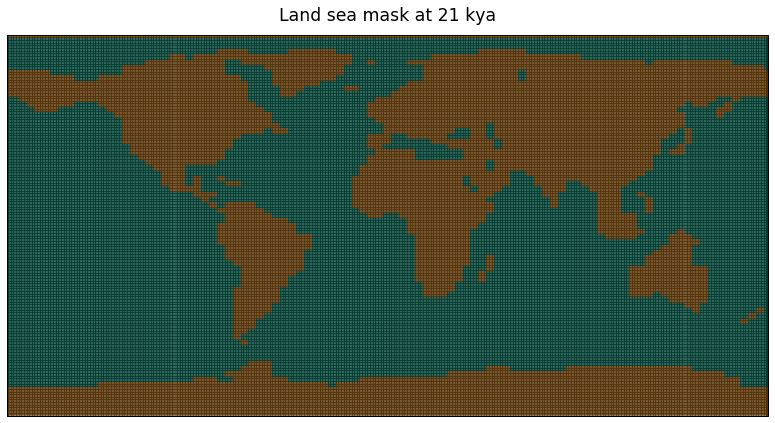

In [3]:
projection_map = ccrs.PlateCarree()

lsm = ds_lsm.lsm.values

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.8)
axMap.set_global()
axMap.set_title("Land sea mask at 21 kya")

**Ice sheet reconstruction** : 2 dimensional time serie of ice thickness (*HGLOBH*)

In [4]:
ds_hice = xr.open_dataset('/Documents/Documents/Cours/PHD/data/Proj_GLAC1D/routed_fwf/GLAC1DHiceF26.nc')
# ds_hice = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1DHiceF26.nc')
lon_glac1D, lat_glac1D, t_glac1d = ds_hice.XLONGLOBP5.values, ds_hice.YLATGLOBP25.values, ds_hice.T122KP1.values
lon_glac1D_b, lat_glac1D_b = tb.create_coordinate_edges(lon_glac1D), tb.create_coordinate_edges(lat_glac1D)
print(ds_hice)

<xarray.Dataset>
Dimensions:      (T122KP1: 261, XLONGLOBP5: 720, YLATGLOBP25: 720)
Coordinates:
  * XLONGLOBP5   (XLONGLOBP5) float64 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * YLATGLOBP25  (YLATGLOBP25) float64 -89.88 -89.62 -89.38 ... 89.62 89.88
  * T122KP1      (T122KP1) float64 -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Data variables:
    HGLOBH       (T122KP1, YLATGLOBP25, XLONGLOBP5) float64 ...
Attributes:
    history:      FERRET V6.96   10-Aug-17
    Conventions:  CF-1.6
    title:        GLAC1D ice thickness Field, Lev Tarasov


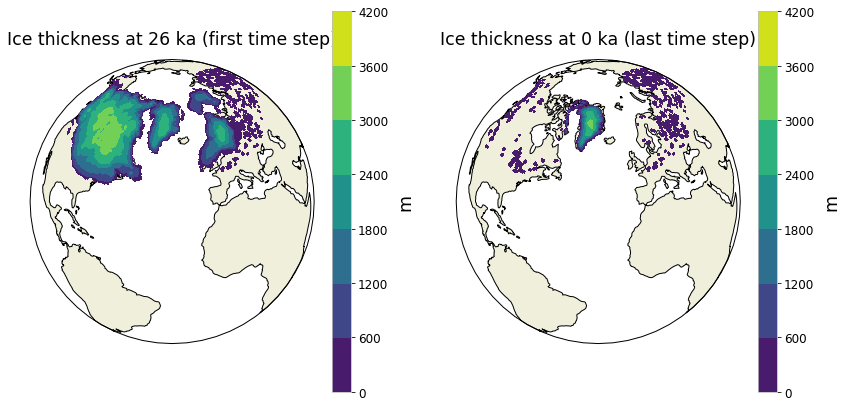

In [5]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)
figMap,(axStart, axEnd) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(14,7))

mask_hice_26 = ds_hice.HGLOBH.sel(T122KP1=-26).values
mask_hice_26 = np.where(mask_hice_26==0, np.NAN, mask_hice_26)
cf_26 = axStart.contourf(lon_glac1D, lat_glac1D, mask_hice_26, transform=ccrs.PlateCarree())
axStart.set_global()
axStart.set_title("Ice thickness at 26 ka (first time step)")
axStart.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cf_26, ax=axStart, label="m")

mask_hice_0 = ds_hice.HGLOBH.sel(T122KP1=-0).values
mask_hice_0 = np.where(mask_hice_0==0, np.NAN, mask_hice_0)
cf_0 = axEnd.contourf(lon_glac1D, lat_glac1D, mask_hice_0, transform=ccrs.PlateCarree())
axEnd.set_global()
axEnd.set_title("Ice thickness at 0 ka (last time step)")
axEnd.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cf_0, ax=axEnd, label="m")

**Ice sheet reconstruction** : 2 dimensional routing map of water basin. *IX* is the longitude index and *JY* is the latitude index, conversion based on provided readme file (*/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1Dpointer_README.txt*)

In [6]:
ds_pointer = xr.open_dataset('/Documents/Documents/Cours/PHD/data/Proj_GLAC1D/routed_fwf/GLAC1DdrainagePointerF26ka.nc')
# ds_pointer = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1DdrainagePointerF26ka.nc')
print(ds_pointer)

<xarray.Dataset>
Dimensions:      (T40H1: 261, XLONGLOBP5: 720, YLATGLOBP25: 720)
Coordinates:
  * XLONGLOBP5   (XLONGLOBP5) float64 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * YLATGLOBP25  (YLATGLOBP25) float64 -89.88 -89.62 -89.38 ... 89.62 89.88
  * T40H1        (T40H1) float64 -26.0 -25.9 -25.8 -25.7 ... -0.3 -0.2 -0.1 0.0
Data variables:
    IX           (T40H1, YLATGLOBP25, XLONGLOBP5) float32 ...
    JY           (T40H1, YLATGLOBP25, XLONGLOBP5) float32 ...
Attributes:
    history:      FERRET V6.96   10-Aug-17
    Conventions:  CF-1.6
    title:        GLAC1D drainage Pointer Field, Lev Tarasov


(lon,lat) [index_lon,index_lat] : (275.25, 47.625) [(190, 550)] -> (286.75, 38.375) [(213.0, 513.0)]
(lon,lat) [index_lon,index_lat] : (272.75, 29.375) [(185, 477)] -> (272.75, 29.375) [(185.0, 477.0)]
(lon,lat) [index_lon,index_lat] : (330.25, -64.875) [(300, 100)] -> (330.25, -64.875) [(300.0, 100.0)]


Text(0.5, 1.0, 'Sample routing points')

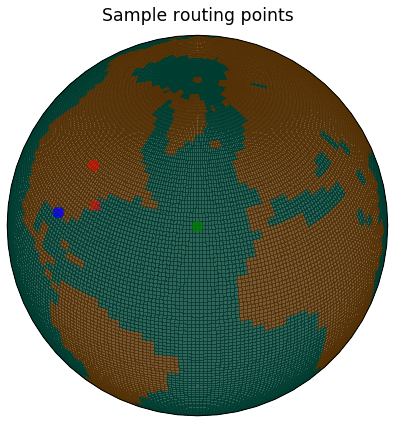

In [7]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

# Indexes to coordinates conversion
IX_lon = ds_pointer.IX.sel(T40H1=-26).values*0.5 - 180.25 + 360
JY_lat = 90.125 - ds_pointer.JY.sel(T40H1=-26).values*0.25 

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.8)

# Point on land
i, j = 190,550
axMap.scatter(lon_glac1D[i], lat_glac1D[j], transform=ccrs.PlateCarree(), s=100, c="r", alpha=0.5)
axMap.scatter(IX_lon[j,i], JY_lat[j,i], transform=ccrs.PlateCarree(), s=100, c="r", alpha=0.5, marker="X")
i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
print(f"(lon,lat) [index_lon,index_lat] : {lon_glac1D[i], lat_glac1D[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")

# Point on the edge of the land sea mask
i, j = 185, 477
axMap.scatter(lon_glac1D[i], lat_glac1D[j], transform=ccrs.PlateCarree(), s=100, c="b", alpha=0.5)
axMap.scatter(IX_lon[j,i], JY_lat[j,i], transform=ccrs.PlateCarree(), s=100, c="b", alpha=0.5, marker="X")
i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
print(f"(lon,lat) [index_lon,index_lat] : {lon_glac1D[i], lat_glac1D[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")

# Point in the ocean
i, j = 300,100
axMap.scatter(lon_glac1D[i], lat_glac1D[j], transform=ccrs.PlateCarree(), s=100, c="g", alpha=0.5)
axMap.scatter(IX_lon[j,i], JY_lat[j,i], transform=ccrs.PlateCarree(), s=100, c="g", alpha=0.5, marker="X")
i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
print(f"(lon,lat) [index_lon,index_lat] : {lon_glac1D[i], lat_glac1D[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")

axMap.set_global()
axMap.set_title("Sample routing points")

## Routing method

In a script, the routing method should be called as follows (we limit the number of steps here to prevent unecessecary computation time). The rest of the notebook will be decomposed to understand each steps individually.

__ Routing algorithm
Reuse existing file: conservative_720x720_144x288.nc
____ Computation time step : 0.
____ Routing method.
____ Overlapping method with double-cross mode.
____ Applying mask processing with differential mode.
____ Computation time step : 1.
____ Routing method.
____ Overlapping method with double-cross mode.
____ Applying mask processing with differential mode.


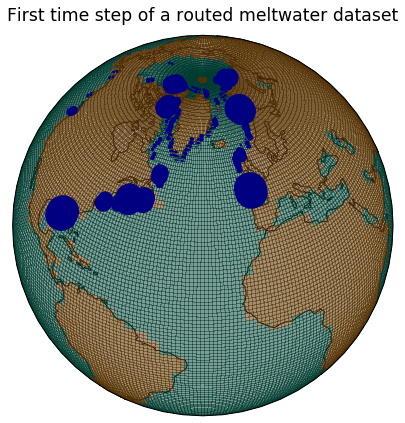

In [8]:
routed_mw = routing.routing(ds_hice, ds_pointer, ds_lsm, mode_flux="Volume", mode_lon="double",
                            mode_shape="cross", mode_smooth="differential", t_debug=2)

projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)

x,y,s = plotting.scatter_mask(routed_mw[0])
axMap.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axMap.set_global()
axMap.set_title("First time step of a routed meltwater dataset")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

## Conversion and Routing Algoritm

The first thing to do is to convert variation of the ice sheet into a meltwater flux for each points of the icesheet. Then we use the routing map to determine where will this water be released. We show here an example for one time step, but the complete method itterate through time to return a time serie.

In [9]:
# Conversion method
t = np.where(t_glac1d == -21)[0][0]
converted_mask = routing.hi_to_discharge(ds_hice, t, "Volume")

# Routing method
ix, jy = ds_pointer.IX.sel(T40H1=-21).values, ds_pointer.JY.sel(T40H1=-21).values
routed_mask = routing.routing_method(converted_mask, ix, jy)

____ Computation time step : 50.
____ Routing method.


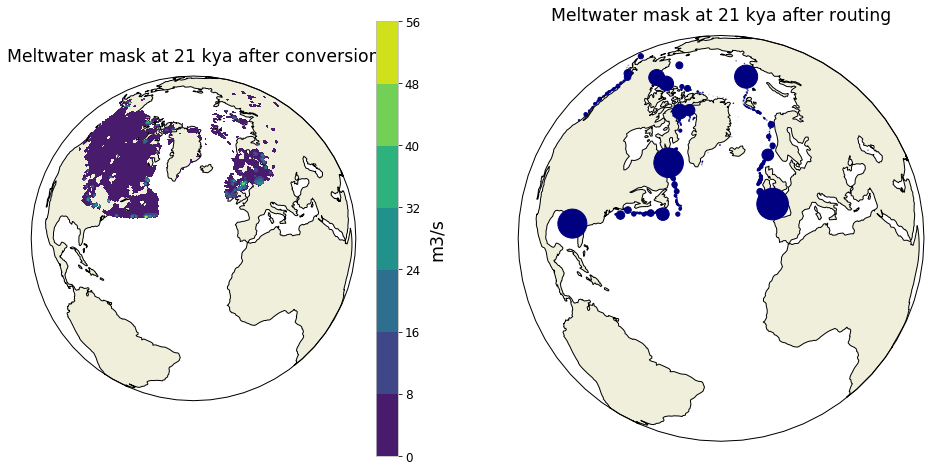

In [10]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)
figMap,(axConverted, axRouted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(16,8))

converted_mask = np.where(converted_mask==0, np.NAN, converted_mask)
cf_converted = axConverted.contourf(lon_glac1D, lat_glac1D, converted_mask, transform=ccrs.PlateCarree())
axConverted.set_global()
axConverted.set_title("Meltwater mask at 21 kya after conversion")
axConverted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cf_converted, ax=axConverted, label="m3/s")

x,y,s = plotting.scatter_mask(routed_mask)
axRouted.scatter(lon_glac1D[x], lat_glac1D[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axRouted.set_global()
axRouted.set_title("Meltwater mask at 21 kya after routing")
axRouted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

# TO DO : add size for size for scale in the scatter method.

## Regridding algorithm

The GLAC1D mask doesn't have the same dimension than the HadCM3 files : one should therefore regrid these files to the HadCM3 dimensions. To see a benchmark of the different available methods check misc_demo. We make sure at the end that the total flux have been conserved. The spreading of the release points results from the interpolation method.

In [11]:
regridder = tb.HadCM3_regridding_method(ds_hice, ds_lsm, reuse_weights=True)
hadcm3_mask = regridder(routed_mask)
hadcm3_mask = hadcm3_mask * np.sum(routed_mask) / np.sum(hadcm3_mask)  # to correct the total flux

Reuse existing file: conservative_720x720_144x288.nc


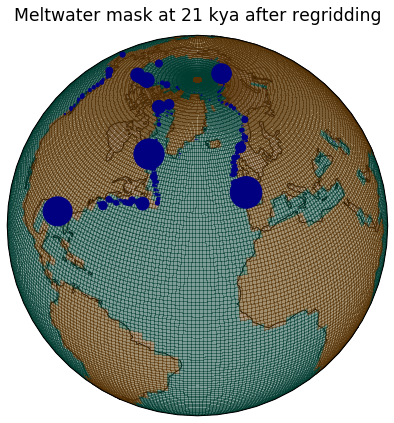

In [12]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)

x,y,s = plotting.scatter_mask(hadcm3_mask)
axMap.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axMap.set_global()
axMap.set_title("Meltwater mask at 21 kya after regridding")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

## Overlaping algorithm

The last plot highlight the fact that some relese points may overlap the lad sea mask, leading to unconsistencies in the simulation. We therefore use an algorithm to redirect meltwater discharge points to the closest sea point. Since the definition of close is not trivial and depend on the grid, we propose different algorithm that are described on *misc_demo*. The meltwater is equally distributed between points at the same distance.

Text(0.5, 1.0, 'Overlaping points with PI ice shet and 26ka land-sea mask')

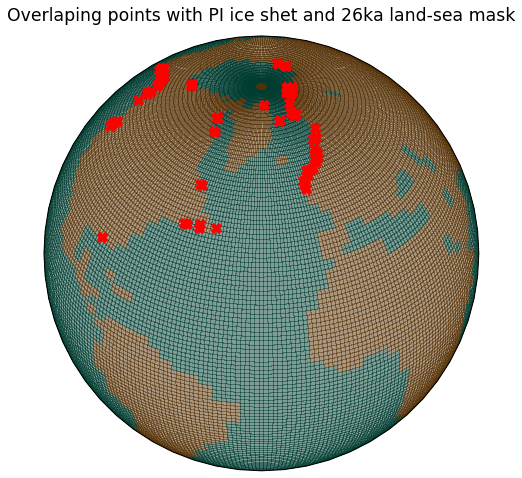

In [13]:
# Algorithm to get the overlaping points

lon_overlap, lat_overlap = [], [],
for i in range(len(lon_hadcm3)):
    for j in range(len(lat_hadcm3)):
        if hadcm3_mask[j, i] != 0 and lsm[j, i] == 1:
            lon_overlap.append(lon_hadcm3[i])
            lat_overlap.append(lat_hadcm3[j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_overlap, lat_overlap, transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.set_global()
axMap.set_title("Overlaping points with PI ice shet and 26ka land-sea mask")

We can check that the algorithm by plotting several sample points using this quick method (not in the package)

In [14]:
def sea_neighbours(i, j, mode_lon="double", mode_shape="cross"):
    n_i, n_j = len(lon_hadcm3), len(lat_hadcm3)
    radius, land_condition, i_sea_points, j_sea_points = 0, True, [], []
    while land_condition:
        for i_2 in range(- radius, radius + 1):
            for j_2 in routing.get_neighbours(radius, mode_lon, mode_shape, i_2):
                i_test = (i + i_2) % n_i
                j_test = min(max(j + j_2, 0), n_j - 1)
                if lsm[j_test, i_test] == 0:
                    i_sea_points.append(i_test)
                    j_sea_points.append(j_test)
                    land_condition = False
        radius += 1
    return i_sea_points, j_sea_points

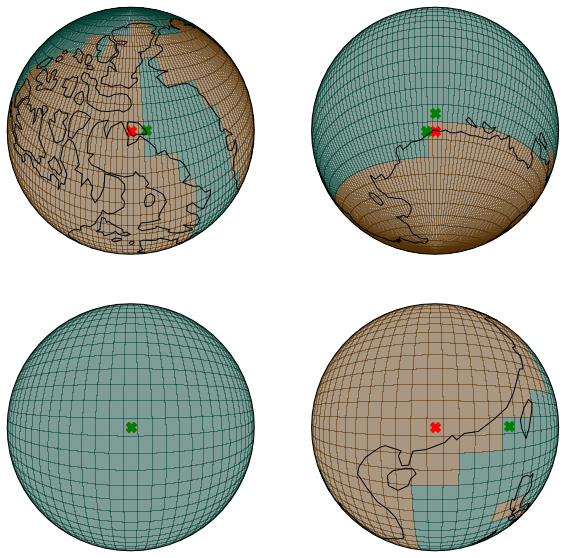

In [15]:
# On the edge
i_edge, j_edge = 224, 130
i_sea_edge,j_sea_edge = sea_neighbours(i_edge, j_edge)

# Double distribution
i_double, j_double = 180, 12
i_sea_double,j_sea_double = sea_neighbours(i_double, j_double)

# In the ocean
i_ocn, j_ocn = 162, 100
i_sea_ocn,j_sea_ocn = sea_neighbours(i_ocn, j_ocn)

# On land
i_lnd, j_lnd = 90, 90
i_sea_lnd,j_sea_lnd = sea_neighbours(i_lnd, j_lnd)


figMap = plt.figure(figsize=(10,10))

axEdge = plt.subplot(221, projection=ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_edge], central_latitude=lat_hadcm3[j_edge],
                                                                 satellite_height=300000))
axEdge.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axEdge.scatter(lon_hadcm3[i_edge], lat_hadcm3[j_edge], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axEdge.scatter(lon_hadcm3[i_sea_edge] ,lat_hadcm3[j_sea_edge], transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axEdge.coastlines()
axEdge.set_global()

axDouble = plt.subplot(222, projection=ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_double], central_latitude=lat_hadcm3[j_double],
                                                                 satellite_height=300000))
axDouble.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axDouble.scatter(lon_hadcm3[i_double], lat_hadcm3[j_double], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axDouble.scatter(lon_hadcm3[i_sea_double] ,lat_hadcm3[j_sea_double], transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axDouble.coastlines()
axDouble.set_global()

axOcn = plt.subplot(223, projection=ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_ocn], central_latitude=lat_hadcm3[j_ocn],
                                                                 satellite_height=300000))
axOcn.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axOcn.scatter(lon_hadcm3[i_ocn], lat_hadcm3[j_ocn], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axOcn.scatter(lon_hadcm3[i_sea_ocn] ,lat_hadcm3[j_sea_ocn], transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axOcn.coastlines()
axOcn.set_global()

axLnd = plt.subplot(224, projection=ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_lnd], central_latitude=lat_hadcm3[j_lnd],
                                                                 satellite_height=300000))
axLnd.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axLnd.scatter(lon_hadcm3[i_lnd], lat_hadcm3[j_lnd], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axLnd.scatter(lon_hadcm3[i_sea_lnd] ,lat_hadcm3[j_sea_lnd], transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axLnd.coastlines()
axLnd.set_global()

These steps can be sum up in a single function. We turned on the verbose mode to display the modifications.

____ Overlapping method with double-cross mode.
____ Shifted (2, 121) : 0.001499630684992469 -> [(1, 121)])
____ Shifted (2, 122) : 2.758084339033437 -> [(1, 122)])
____ Shifted (3, 122) : 3.3506444893032197 -> [(1, 122), (3, 123)])
____ Shifted (4, 122) : 14.212113711359303 -> [(4, 123)])
____ Shifted (5, 123) : 47.85796508649292 -> [(4, 123)])
____ Shifted (5, 124) : 5.353709252790316 -> [(4, 124)])
____ Shifted (8, 126) : 1.1576201864978395 -> [(7, 126)])
____ Shifted (8, 133) : 1.0164855327307145 -> [(7, 133)])
____ Shifted (8, 134) : 9.299615088542499 -> [(7, 134)])
____ Shifted (9, 126) : 0.0678748786186384 -> [(7, 126), (9, 127)])
____ Shifted (9, 133) : 2.148498304709157 -> [(7, 133), (9, 132)])
____ Shifted (9, 134) : 1.1104613351484293e-05 -> [(7, 134), (9, 135)])
____ Shifted (10, 126) : 0.01885605651449041 -> [(10, 127)])
____ Shifted (10, 133) : 27.194575304308962 -> [(10, 132)])
____ Shifted (11, 133) : 15.703986658848711 -> [(11, 132)])
____ Shifted (14, 128) : 0.4915590

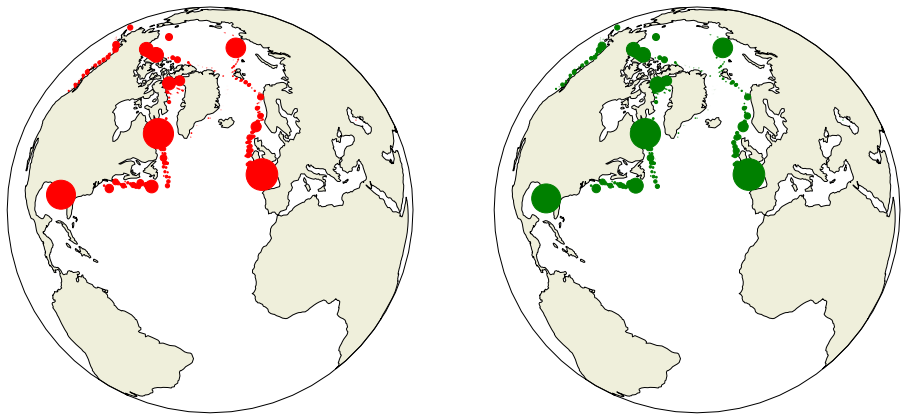

In [16]:
shifted_mask = routing.overlapping_method(hadcm3_mask, lsm, mode_lon="double", mode_shape="cross", verbose=True)

projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,(axOut, axShifted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(16,8))

x,y,s = plotting.scatter_mask(hadcm3_mask)
axOut.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="red")
axOut.set_global()
axOut.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

x,y,s = plotting.scatter_mask(shifted_mask)
axShifted.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="green")
axShifted.set_global()
axShifted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

print(f"Before shifting -> flux : {np.nansum(hadcm3_mask):.2f} , max : {np.nanmax(hadcm3_mask):.2f}")
print(f"After shifting  -> flux : {np.nansum(shifted_mask):.2f} , max : {np.nanmax(shifted_mask):.2f}")